In [1]:
import numpy as np
import torch
import torchvision as tv

from PIL import Image
from IPython.display import clear_output, display

In [2]:
arc = np.load('box_sphere.npz')

In [4]:
ds = arc['ds']

In [5]:
ds.shape

(720, 100, 100, 3)

In [6]:
ind = np.arange(ds.shape[0])
np.random.shuffle(ind)

In [7]:
label = np.arange(ds.shape[0]) % 2

In [8]:
sh_ds, sh_label = ds[ind], label[ind]

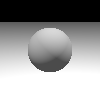

1

In [9]:
t = 11
display(Image.fromarray(sh_ds[t]), sh_label[t])

In [17]:
pt_ds, pt_lbl = torch.from_numpy(sh_ds).float().transpose(1, 3), torch.from_numpy(sh_label)

In [11]:
class Descriminate(torch.nn.Module):
    def __init__(self):
        super(Descriminate, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 3)
        self.mp1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(6, 12, 3)
        self.mp2 = torch.nn.MaxPool2d(2)
        self.lin1 = torch.nn.Linear(12 * 23 * 23, 600)
        self.lin2 = torch.nn.Linear(600, 50)
        self.lin3 = torch.nn.Linear(50, 2)
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.mp1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.mp2(x)
        x = x.view(-1, 12 * 23 * 23)
        x = torch.nn.functional.relu(self.lin1(x))
        x = torch.nn.functional.relu(self.lin2(x))
        x = torch.nn.functional.relu(self.lin3(x))
        return x

In [12]:
m = Descriminate()

In [13]:
ar = m(pt_ds)
ar.shape

torch.Size([720, 2])

In [14]:
crit = torch.nn.CrossEntropyLoss()

In [18]:
estimation = m(pt_ds)
my_loss = crit(estimation, pt_lbl)

In [19]:
my_loss

tensor(0.6117)

In [21]:
optim = torch.optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

In [22]:
for _ in range(100):
    optim.zero_grad()
    estim = m(pt_ds)
    loss = crit(estim, pt_lbl)
    loss.backward()
    optim.step()
    
    clear_output()
    display(float(loss))

3.627867408795282e-05

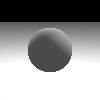

tensor([[  1.9459,  12.9928]])

''

''

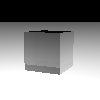

tensor([[ 10.7428,   0.0000]])

''

''

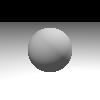

tensor([[  2.6817,  12.1450]])

''

''

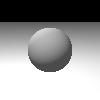

tensor([[  2.1549,  12.6798]])

''

''

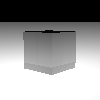

tensor([[ 10.6849,   0.0283]])

''

''

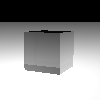

tensor([[ 10.8754,   0.0000]])

''

''

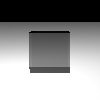

tensor([[ 11.6084,   0.1257]])

''

''

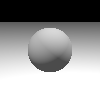

tensor([[  2.7957,  11.8812]])

''

''

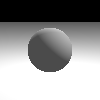

tensor([[  2.0237,  12.9555]])

''

''

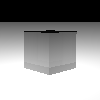

tensor([[ 10.7844,   0.0000]])

''

''

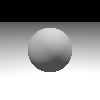

tensor([[  2.8060,  11.8390]])

''

''

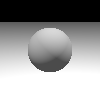

tensor([[  2.8182,  11.8191]])

''

''

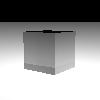

tensor([[ 10.6938,   0.0000]])

''

''

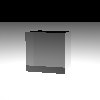

tensor([[ 11.2917,   0.3202]])

''

''

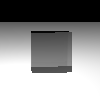

tensor([[ 11.3670,   0.5928]])

''

''

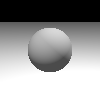

tensor([[  2.6722,  12.1627]])

''

''

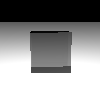

tensor([[ 11.5912,   0.3535]])

''

''

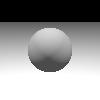

tensor([[  2.8328,  11.6766]])

''

''

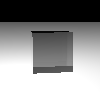

tensor([[ 11.2125,   1.0589]])

''

''

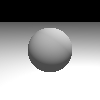

tensor([[  2.3927,  12.7689]])

''

''

In [51]:
for t in range(20):
    pic = pt_ds[t].transpose(0, 2).numpy()
    int_pic = pic.astype(np.uint8)
    display(Image.fromarray(int_pic), m(pt_ds[t:t+1]), '', '')